In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import datetime
import json
from pprint import pprint
from IPython.core import display as ICD  # to print multiple nice pandas tables
from collections import defaultdict
import logging
import numpy as np
import io
import gensim
from tqdm import tqdm_notebook, tnrange
import tqdm
import seaborn as sns
sns.set()

In [22]:
import datasets
import classify

In [23]:
from sklearn.linear_model import LogisticRegression
from gensim.models import TfidfModel
class SimpleModel(object):
    def __init__(self, cls = None, use_tfidf=False, w=None):
        self.cls = cls
        if self.cls is None:
            self.cls = LogisticRegression()
        self.use_tfidf = use_tfidf
        self.w=w
        

    def fit(self, X, Y):
        self.dictionary = gensim.corpora.Dictionary(X)
        self.num_terms = len(self.dictionary.dfs)
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            self.tfidf_model = TfidfModel(bow)
            bow = self.tfidf_model[bow]
        if self.w is None:
            self.w = np.ones(self.num_terms)
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            bow = gensim.matutils.Sparse2Corpus(bow.multiply(self.w.reshape(-1,1)))
        self.lsi = gensim.models.LsiModel(bow, id2word=self.dictionary)
        self.corpus = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        self.cls.fit(self.corpus, Y)
    
    def dw(self, X, Y):
        _ = self.predict(X)
        self.d_embedding = self.cls.dx(self.embedding, Y)
        u = self.lsi.projection.u
        res = self.d_embedding.dot(u.T)
        dw = model.bow.multiply(res.T).sum(axis=1).T.A1
        return dw
        
    
    def predict(self, X):
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            bow = self.tfidf_model[bow]
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.bow = bow
            bow = bow.multiply(self.w.reshape(-1,1))
            bow = gensim.matutils.Sparse2Corpus(bow)

        self.embedding = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        Yhat = self.cls.predict(self.embedding)
        return Yhat
    
    def score(self, X, Y):
        Yhat = self.predict(X)
        return 1-((Yhat-Y)**2).mean()
    
    def update(self, X, Y):
        pass

In [24]:
def noice_like(like, spread=0.01):
    rnd = np.random.random(size=like.shape)
    rnd *= spread
    rnd -= spread/2
    return rnd

# Check how balanced are the datasets

In [25]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]

In [26]:
for dataset in all_datasets:
    print(dataset.name(), dataset.baseline())

CRDataset 0.6376158940397351
MRDataset 0.5
SUBJDataset 0.5
MPQADataset 0.6877239298510277


In [27]:
results = {}

# Testing lsa + sklearn logistic regression 

In [48]:
def test_simple_model(model, dataset, iters=1, tag=None):
    precisions = []
    for it in tnrange(iters):
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    print(dataset.name())
    if tag is not None:
        results[('simple', tag, dataset.name())] = (train, test)
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

In [49]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model(model, dataset, 5, 'default')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




CRDataset
Train precision 0.7839269944068296 0.7848690020606417 0.7859876361495437
Test precision 0.7513227513227514 0.7576719576719577 0.7671957671957672


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.687441375716519 0.6895674830640959 0.691089108910891
Test precision 0.6588566073102156 0.6682286785379569 0.6766635426429242


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.8855555555555555 0.8865555555555555 0.887888888888889
Test precision 0.868 0.8744 0.881


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.7591409114719748 0.7612781561026716 0.7623886851754845
Test precision 0.7342130065975494 0.7406220546654099 0.7474081055607917


# Testing lsa + custom logistic regression 

In [51]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.CustomClassifier())
    test_simple_model(model, dataset, 5, 'custom_regression')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.6376214306741242 0.6376214306741242 0.6376214306741242
Test precision 0.6375661375661376 0.6375661375661376 0.6375661375661376


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.500156331422616 0.6201980198019802 0.706618030224075
Test precision 0.4995313964386129 0.5964386129334583 0.6644798500468603


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.8795555555555555 0.8876 0.8937777777777778
Test precision 0.844 0.8573999999999999 0.865


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.6876898899947617 0.6876898899947617 0.6876898899947617
Test precision 0.6880301602262017 0.6880301602262017 0.6880301602262017


We see real decrease against sklearn classsifier in some tasks. In CR and MPQAD we hit the baseline, which is bad.

In [50]:
results

{('simple',
  'default',
  'CRDataset'): ((0.7851045039740948,
   0.7845157491904622,
   0.7839269944068296,
   0.7859876361495437,
   0.7848101265822784), (0.7671957671957672,
   0.7566137566137566,
   0.753968253968254,
   0.7513227513227514,
   0.7592592592592593)),
 ('simple',
  'default',
  'MPQADataset'): ((0.7591409114719748,
   0.7617600838135149,
   0.7623886851754845,
   0.7620743844944997,
   0.7610267155578837), (0.7436380772855796,
   0.7408105560791706,
   0.7474081055607917,
   0.7370405278039585,
   0.7342130065975494)),
 ('simple',
  'default',
  'MRDataset'): ((0.691089108910891,
   0.6896300156331423,
   0.687441375716519,
   0.6890046899426785,
   0.6906722251172486), (0.6635426429240863,
   0.6663542642924086,
   0.6588566073102156,
   0.6757263355201499,
   0.6766635426429242)),
 ('simple',
  'default',
  'SUBJDataset'): ((0.887888888888889,
   0.8865555555555555,
   0.8855555555555555,
   0.8868888888888888,
   0.885888888888889), (0.881, 0.875, 0.868, 0.876, 0.8

# Add tfidf

In [52]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model(model, dataset, 5, 'tfidf')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.7895201648513395 0.7916396820724168 0.7959964674712983
Test precision 0.7592592592592593 0.76984126984127 0.7751322751322751


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.7153725898905681 0.7187910369984367 0.7222511724856696
Test precision 0.7047797563261481 0.7145267104029991 0.7347703842549204


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.894 0.8964444444444444 0.8983333333333333
Test precision 0.884 0.89 0.894


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.7823991618648507 0.7852069146149816 0.7878470403352541
Test precision 0.7530631479736098 0.75626767200754 0.760603204524034


# Try improwing $w$ with gradient

In [53]:
def gradient_w(model, dataset, alpha=0.01, epochs=150):
    train_scores = []
    test_scores = []
    model.fit(dataset.train_samples(), dataset.train_labels())
    t = tnrange(epochs)
    for e in t:
        w = np.copy(model.w)
        w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
        model = SimpleModel(classify.SkClassifier(), w=w)
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_score = model.score(dataset.train_samples(), dataset.train_labels())
        test_score = model.score(dataset.test_samples(), dataset.test_labels())
        train_scores.append(train_score)
        test_scores.append(test_score)
        t.set_postfix(train_score=train_score, test_score=test_score)
    plt.plot(train_scores)
    plt.plot(test_scores)
    return train_scores, test_scores

In [54]:
def test_simple_model_with_gradient(model, dataset, iters=1, gradient_iters=150, alpha=0.01, tag=None):
    precisions = []
    for it in tnrange(iters):
        _ = gradient_w(model, dataset, alpha, gradient_iters)
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    if tag is not None:
        results[('gradientw', tag, dataset.name())] = (train, test)

    print(dataset.name())
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


CRDataset
Train precision 0.782455107447748 0.7852026297713669 0.7868707683249927
Test precision 0.753968253968254 0.7557319223985891 0.7566137566137566


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MRDataset
Train precision 0.6896300156331423 0.6919228764981762 0.6952579468473163
Test precision 0.6701030927835052 0.6760387378944079 0.6804123711340206


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


SUBJDataset
Train precision 0.8854444444444445 0.886 0.8863333333333333
Test precision 0.867 0.871 0.873


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MPQADataset
Train precision 0.7592456783656365 0.7615156277283045 0.7637506547930853
Test precision 0.7370405278039585 0.7408105560791706 0.7436380772855796


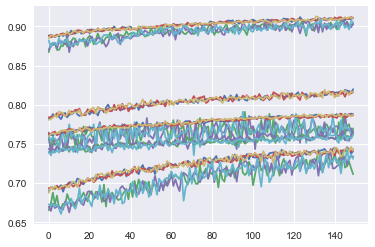

In [55]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, 3, tag='default')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


CRDataset
Train precision 0.7895201648513395 0.7911883034049652 0.7936414483367678
Test precision 0.7671957671957672 0.7707231040564375 0.7751322751322751


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MRDataset
Train precision 0.7150599270453362 0.7163105784262637 0.7172485669619594
Test precision 0.7057169634489222 0.7119650109340832 0.7150890346766635


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


SUBJDataset
Train precision 0.8973333333333333 0.898 0.8983333333333333
Test precision 0.885 0.891 0.897


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))


MPQADataset
Train precision 0.7853326348873756 0.7870787497817356 0.7887899423782085
Test precision 0.7530631479736098 0.7549481621112158 0.7558906691800189


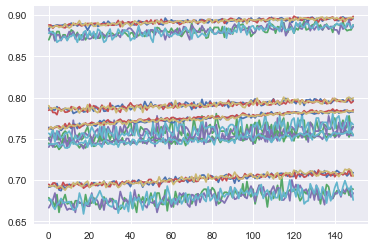

In [56]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, 3, tag='tfidf')

In [60]:
import pickle

In [61]:
results

{('gradientw',
  'default',
  'CRDataset'): ((0.7868707683249927,
   0.78628201354136,
   0.782455107447748), (0.7566137566137566, 0.7566137566137566, 0.753968253968254)),
 ('gradientw',
  'default',
  'MPQADataset'): ((0.7637506547930853,
   0.7615505500261918,
   0.7592456783656365), (0.7370405278039585,
   0.7417530631479736,
   0.7436380772855796)),
 ('gradientw',
  'default',
  'MRDataset'): ((0.6952579468473163,
   0.6896300156331423,
   0.6908806670140698), (0.6804123711340206,
   0.6776007497656982,
   0.6701030927835052)),
 ('gradientw',
  'default',
  'SUBJDataset'): ((0.8862222222222222,
   0.8854444444444445,
   0.8863333333333333), (0.873, 0.867, 0.873)),
 ('gradientw',
  'tfidf',
  'CRDataset'): ((0.7904032970267884,
   0.7895201648513395,
   0.7936414483367678), (0.7698412698412699,
   0.7671957671957672,
   0.7751322751322751)),
 ('gradientw',
  'tfidf',
  'MPQADataset'): ((0.7887899423782085,
   0.7853326348873756,
   0.7871136720796228), (0.7558906691800189,
   0.7558

In [65]:
if False:
    pickle.dump(results, open('results.pickle', 'wb'))

In [68]:
r  = pickle.load(open('results.pickle', 'rb'))

{('gradientw',
  'default',
  'CRDataset'): ((0.7868707683249927,
   0.78628201354136,
   0.782455107447748), (0.7566137566137566, 0.7566137566137566, 0.753968253968254)),
 ('gradientw',
  'default',
  'MPQADataset'): ((0.7637506547930853,
   0.7615505500261918,
   0.7592456783656365), (0.7370405278039585,
   0.7417530631479736,
   0.7436380772855796)),
 ('gradientw',
  'default',
  'MRDataset'): ((0.6952579468473163,
   0.6896300156331423,
   0.6908806670140698), (0.6804123711340206,
   0.6776007497656982,
   0.6701030927835052)),
 ('gradientw',
  'default',
  'SUBJDataset'): ((0.8862222222222222,
   0.8854444444444445,
   0.8863333333333333), (0.873, 0.867, 0.873)),
 ('gradientw',
  'tfidf',
  'CRDataset'): ((0.7904032970267884,
   0.7895201648513395,
   0.7936414483367678), (0.7698412698412699,
   0.7671957671957672,
   0.7751322751322751)),
 ('gradientw',
  'tfidf',
  'MPQADataset'): ((0.7887899423782085,
   0.7853326348873756,
   0.7871136720796228), (0.7558906691800189,
   0.7558

In [22]:
alpha = 0.01
dataset = datasets.CRDataset()
model = SimpleModel(classify.SkClassifier())
model.fit(dataset.train_samples(), dataset.train_labels())
_ = gradient_w(model, dataset, 150)


  1%|▏         | 2/150 [00:07<08:59,  3.65s/it, test_score=0.746, train_score=0.815]
Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

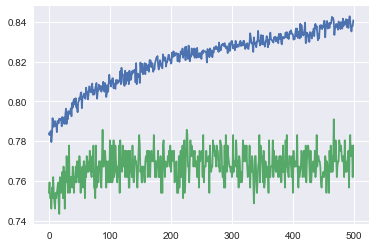

In [128]:
plt.plot(train_scores)
plt.plot(test_scores)